In [35]:
from utils import pickle_load
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import pandas as pd
from evaluate import compute_sim, evaluate

def l2norm(embs):
    return {k: v/np.linalg.norm(v) for k, v in embs.items()}

infer_dir = 'D:'
# infer_dir = 'C:/Users/msi/Downloads/drive-download-20220218T051534Z-001'

train_embs = pickle_load(f"{infer_dir}/train_embs.pkl")
test_embs = pickle_load(f"{infer_dir}/test_embs.pkl")
val_embs = pickle_load(f"{infer_dir}/val_embs.pkl")
train_df = pd.read_csv('data/train_kfold.csv')

# train_embs = l2norm(train_embs)
# test_embs = l2norm(test_embs)
# val_embs = l2norm(val_embs)
len(train_embs) + len(val_embs)

51033

In [36]:
val_df = train_df[train_df.subset == 'test'].reset_index()
val_map = dict(zip(val_df.image, val_df.individual_id))
train_map = dict(zip(train_df.image, train_df.individual_id))
# val_imgs = val_df.image.unique()
# val_embs = {k: train_embs[k] for k in val_imgs}

In [37]:
from evaluate import compute_sim, evaluate, map_per_image

score, val_sim_df = evaluate(train_df, train_embs, val_embs)
val_sim_df["gt"] = val_sim_df.image.map(val_map)
val_sim_df["map"] = val_sim_df.apply(lambda row: map_per_image(row["gt"], row.predictions.split(" ")), axis=1)
val_sim_df = val_sim_df.sort_values("map")
score

100%|██████████| 5710/5710 [00:05<00:00, 952.67it/s] 


0.6664740221833041

C:\Users\msi\AppData\Local\Programs\Python\Python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


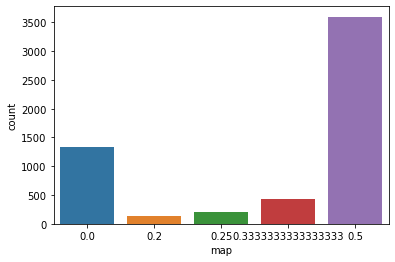

In [31]:
val_sim_df = val_sim_df.sort_values("map")
sns.countplot(val_sim_df.map)

In [32]:
# val_sim_df

sim_df = compute_sim(train_df, {**train_embs, **val_embs}, test_embs)
sim_df[["image", "predictions"]].to_csv("submission.csv", index=False)
sim_df.head()

100%|██████████| 27956/27956 [00:24<00:00, 1121.79it/s]


,image,predictions
0,fb090727f1a56e.jpg,new_individual 2d3d88e82a93 e63f3e1c1205 4b5d5...
1,d372cd2783de6d.jpg,6ad3713dda3a new_individual 164b7f79dcb7 8b7c2...
2,fdbeff47a50473.jpg,new_individual 394e1afdf974 25945848e4cb 575e6...
3,5d8012782373cc.jpg,9582cc692d85 new_individual 79c94459ece0 20e1a...
4,7fab132e1ab5a7.jpg,9a66d006b36e new_individual 07a477b6a091 250c3...


GT 5ca3ea3464fe 0.3333333333333333


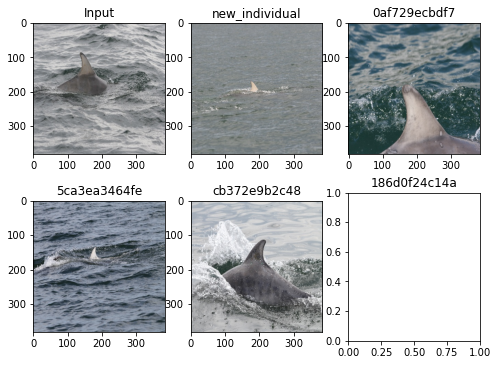

In [33]:
def random_show(sim_df, is_val=False):
    sim_df = sim_df.copy()
    if is_val:
        sim_df = sim_df[sim_df["map"] < 0.5]
        sample = sim_df.iloc[np.random.choice(sim_df.index)]
        img1 = cv2.imread(f'D:/whale_data/train_images-384-384/train_images-384-384/{sample.image}')[:, :, ::-1]
        print("GT", sample["gt"], sample["map"])
    else:
        sample = sim_df.iloc[np.random.choice(sim_df.index)]
        img1 = cv2.imread(f'D:/whale_data/test_images-384-384/test_images-384-384/{sample.image}')[:, :, ::-1]
        
    imgs = [img1]

    ids = sample.predictions.split(" ")
    for i in range(5):
        if ids[i] != 'new_individual':
            path = train_df[train_df.individual_id == ids[i]].values[0][0]
            img = cv2.imread(f'D:/whale_data/train_images-384-384/train_images-384-384/{path}')[:, :, ::-1]
            imgs.append(img)

    fig = plt.figure(figsize=(8, 6))
    columns = 3
    rows = 2
    for i in range(0, columns*rows):
        fig.add_subplot(rows, columns, i+1)
        if i == 0:
            plt.title('Input')
        else:
            plt.title(ids[i-1])
        if i < len(imgs):
            
            plt.imshow(imgs[i])
    plt.show()

random_show(val_sim_df, is_val=True)
# random_show(sim_df, is_val=False)

In [34]:
raise
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(n_neighbors=100,metric='cosine')

train_k, train_v = dict2list(train_embs)
test_k, test_v = dict2list(test_embs)
knn.fit(train_v)

RuntimeError: No active exception to reraise

In [ ]:
distances, idxs = knn.kneighbors(test_v, 100, return_distance=True)

In [ ]:
test_df = []
train_k = np.asarray(train_k)
img2id = dict(zip(train_df.image, train_df.individual_id))

for i in tqdm(range(len(test_k))):
    dist, idx = distances[i], idxs[i]
    for d, id in zip(dist, idx):
        img_id = train_k[id]
        tar = img2id[img_id]
        test_df.append([test_k[i], tar, d]) 
    

test_df = pd.DataFrame(test_df, columns=['image', 'target', 'distances'])
test_df['confidence'] = 1-test_df['distances']
test_df = test_df.groupby(['image','target']).confidence.max().reset_index()
test_df = test_df.sort_values('confidence',ascending=False).reset_index(drop=True)
test_df.to_csv('test_neighbors.csv')
test_df.image.value_counts().value_counts()

In [ ]:
sample_list = ['938b7e931166', '5bf17305f073', '7593d2aee842', '7362d7a01d00','956562ff2888']


In [ ]:
predictions = {}
for i,row in tqdm(test_df.iterrows(), total=len(test_df)):
    if row.image in predictions:
        if len(predictions[row.image])==5:
            continue
        predictions[row.image].append(row.target)
    elif row.confidence > 0.5:
        predictions[row.image] = [row.target,'new_individual']
    else:
        predictions[row.image] = ['new_individual',row.target]

for x in tqdm(predictions):
    if len(predictions[x])<5:
        remaining = [y for y in sample_list if y not in predictions]
        predictions[x] = predictions[x]+remaining
        predictions[x] = predictions[x][:5]
    predictions[x] = ' '.join(predictions[x])
    
predictions = pd.Series(predictions).reset_index()
predictions.columns = ['image','predictions']
predictions.to_csv('submission.csv',index=False)
predictions.head()

In [ ]:
# sim_df = sim_df.sort_values('image')
# sim_df.to_csv('submission.csv', index=False)

# s655_df = pd.read_csv('submission_655.csv')
# s655_df= s655_df.sort_values('image')
# s655_df.to_csv('submission_655.csv', index=False)

In [ ]:
sub_df = pd.read_csv("submission.csv")
sub_df["top1"] = sub_df["predictions"].apply(lambda x: x.split(" ")[0])
sub_df2 = pd.read_csv("submission_655.csv")
sub_df2["top1"] = sub_df2["predictions"].apply(lambda x: x.split(" ")[0])

sub_df = sub_df.sort_values('image')
sub_df2 = sub_df2.sort_values('image')

0.0005723279439118615